In [212]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pygmt
import os
import yaml
import pandas as pd
import h5py

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon
from scipy import interpolate

In [213]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import mathlib

In [214]:
flag_project = 1

if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
name_project = 'project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/'

In [215]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  ./
dir_project_workspace:  ./
dir_project:  ./project_repartition_v4.0/output_repar_v9.5_04--10-16Hz/


In [216]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [217]:
dir_CC = dir_CC_workspace + info_basic['rdir_CC']
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
#dir_model_fund = dir_project + info_basic['rdir_model_fund']
#dir_model = dir_project + info_basic['rdir_model']
dir_image = dir_project + info_basic['rdir_image'] + 'paper_tomo_Re-srl/'
if os.path.exists(dir_image) == False:
    os.makedirs(dir_image)

In [218]:
rdir_project_probes = info_basic['rdir_project_probes']
rdir_project_targets = info_basic['rdir_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, rdir_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, rdir_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  ./project/output_regular_v9.5_3x7/
dir_project_targets:  ./project/output_regular_v9.5_5x13/


In [219]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

key_subworks_all = info_basic['key_subworks_repick_thresh']
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']

dir_partition_probes = dir_project_probes + info_basic_probes['rdir_partition']
dir_partition_targets = dir_project_targets + info_basic_targets['rdir_partition']
dir_disp_probes  = dir_project_probes + info_basic_probes['rdir_disp_autopick'] 

stations_this = {}
lat_stations_this = {}
lon_stations_this = {}
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_this[key] = stations_this
    lat_stations_this[key] = lat.astype(float)
    lon_stations_this[key] = lon.astype(float)

stations_probes = {}
lat_probes = {}
lon_probes = {}
lon_centroid_probes = []
lat_centroid_probes = []
for probe in probes:
    filepath = dir_partition_probes + str(probe) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_probes[probe] = stations_this
    lat_probes[probe] = lat_this.astype(float)
    lon_probes[probe] = lon_this.astype(float)
    lon_centroid_probes.append(np.mean(lon_this.astype(float)))
    lat_centroid_probes.append(np.mean(lat_this.astype(float)))

stations_targets = {}
lat_targets = {}
lon_targets = {}
lon_centroid_targets = []
lat_centroid_targets = []
for target in targets:
    filepath = dir_partition_targets + str(target) + '.txt'
    stations_this, lat_this, lon_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_targets[target] = stations_this
    lat_targets[target] = lat_this.astype(float)
    lon_targets[target] = lon_this.astype(float)
    lon_centroid_targets.append(np.mean(lon_this.astype(float)))
    lat_centroid_targets.append(np.mean(lat_this.astype(float)))

In [220]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_stations_all = stainfo['latitude'].tolist() 
lon_stations_all = stainfo['longitude'].tolist()

In [221]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lon_centroid_partition = []
lat_centroid_partition = []
for key in key_subworks_all:
    filepath = dir_partition + str(key) + '.txt'
    stations, lat, lon = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat.astype(float)
    lon_stations_partition[key] = lon.astype(float)
    lon_centroid_partition.append(np.mean(lon.astype(float)))
    lat_centroid_partition.append(np.mean(lat.astype(float)))

In [222]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()
name_ref, lat_fault_infer, lon_fault_infer = np.loadtxt('clark_fault_inferred.txt',dtype='str' , unpack=True,delimiter=',')
lon_fault_infer = lon_fault_infer.astype(float)
lat_fault_infer = lat_fault_infer.astype(float)

### Probes and Targets

In [223]:
def extract_probes(target):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stations_targets

    stas = stations_targets[target]
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [224]:
def find_nearest(lon_this,lat_this,lon_stations_all,lat_stations_all):
    lon_stations_all = np.array(lon_stations_all)
    lat_stations_all = np.array(lat_stations_all)
    lon_stations_all = lon_stations_all.reshape(-1,1)
    lat_stations_all = lat_stations_all.reshape(-1,1)
    dist = np.sqrt((lon_stations_all-lon_this)**2+(lat_stations_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    #print(lon_stations_all)
    #print(index)
    return index

In [225]:
flag_red = 0.001
flag_proj = 'M10c'

In [226]:
def moving_average(interval, windowsize):
    window = np.ones(int(windowsize)) / float(windowsize)
    re = np.convolve(interval, window, 'same')
    return re

In [227]:
def extract_err(target,flag_err):
    global probes_this


    f_range = [9,16]
    avg = 12

    probes_this = extract_probes(target)
    stations = set()
    lon_centroid_probe = []
    lat_centroid_probe = []
    for probe in probes_this:
        stations_this = stations_probes[probe]
        stations = stations.union(set(stations_this))
        lon_centroid_probe.append(np.mean( lon_probes[probe]))
        lat_centroid_probe.append(np.mean( lat_probes[probe]))
    stations = list(stations)
    lon_stations_this = []
    lat_stations_this = []
    for sta in stations:
        index = stalist_all.index(sta)
        lon_stations_this.append(lon_stations_all[index])
        lat_stations_this.append(lat_stations_all[index])

    # 读取全部autopick dispersion curves
    disp_all = {}
    for probe in probes_this:
        file_ds = dir_project_probes  + info_basic_probes['rdir_disp_autopick'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
        disp_all[probe] = disp[index,:]

    # find central probe and cluster based on it
    lon_centroid_this = np.mean(lon_stations_this)
    lat_centroid_this = np.mean(lat_stations_this)
    index = find_nearest(lon_centroid_this,lat_centroid_this,lon_centroid_probe,lat_centroid_probe)
    probe_ref = probes_this[index]

    # original partition
    sta_original = set()
    for probe in probes_this:
        sta_original = sta_original.union(stations_probes[probe])
    sta_original = list(sta_original)
    lon_stations_original = []
    lat_stations_original = []
    for sta in sta_original:
        index = stalist_all.index(sta)
        lon_stations_original.append(lon_stations_all[index])
        lat_stations_original.append(lat_stations_all[index])

    # calculate relative error between all probes and reference probe
    err = []
    f_sample = np.linspace(f_range[0],f_range[1],200,endpoint=False)
    f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
    c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
    f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
    c_pick_ref_or = f(f_sample)

    c_pick_ref = moving_average(c_pick_ref_or,avg)

    c_pick = {}
    probe_test = set()
    for probe in probes_this:
        c_pick[probe] = []
        file_ds = dir_project_probes  + info_basic_probes['rdir_disp_autopick'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=f_range[0]) & (disp[:,0]<=f_range[1]))[0]
        disp = disp[index,:]
        f_this = disp[:,0]
        c_this = disp[:,1]


        # 生成插值函数,可以外推
        #f = interpolate.interp1d(f_this,c_this,kind='cubic')
        f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
        c_or = f(f_sample)
        c_pick_new = moving_average(c_or,avg)
        c_pick[probe] = c_pick_new

        max_disp = np.sum( np.maximum(np.array(c_pick_ref),np.array(c_pick[probe])) )
        abs_err = np.sum( np.abs(np.abs(np.array(c_pick_ref))-np.abs(np.array(c_pick[probe]))) )
        err.append(abs_err/max_disp) 
    print(probe_test)
    # pass or not
    index_pass = np.array(err) < flag_err
    probe_pass = np.array(probes_this)[index_pass]
    lon_centroid_pass = np.array(lon_centroid_probe)[index_pass]
    lat_centroid_pass = np.array(lat_centroid_probe)[index_pass]
    err_pass = np.array(err)[index_pass]

    return f_sample,c_pick,c_pick_ref,probe_pass

### New partition comparison

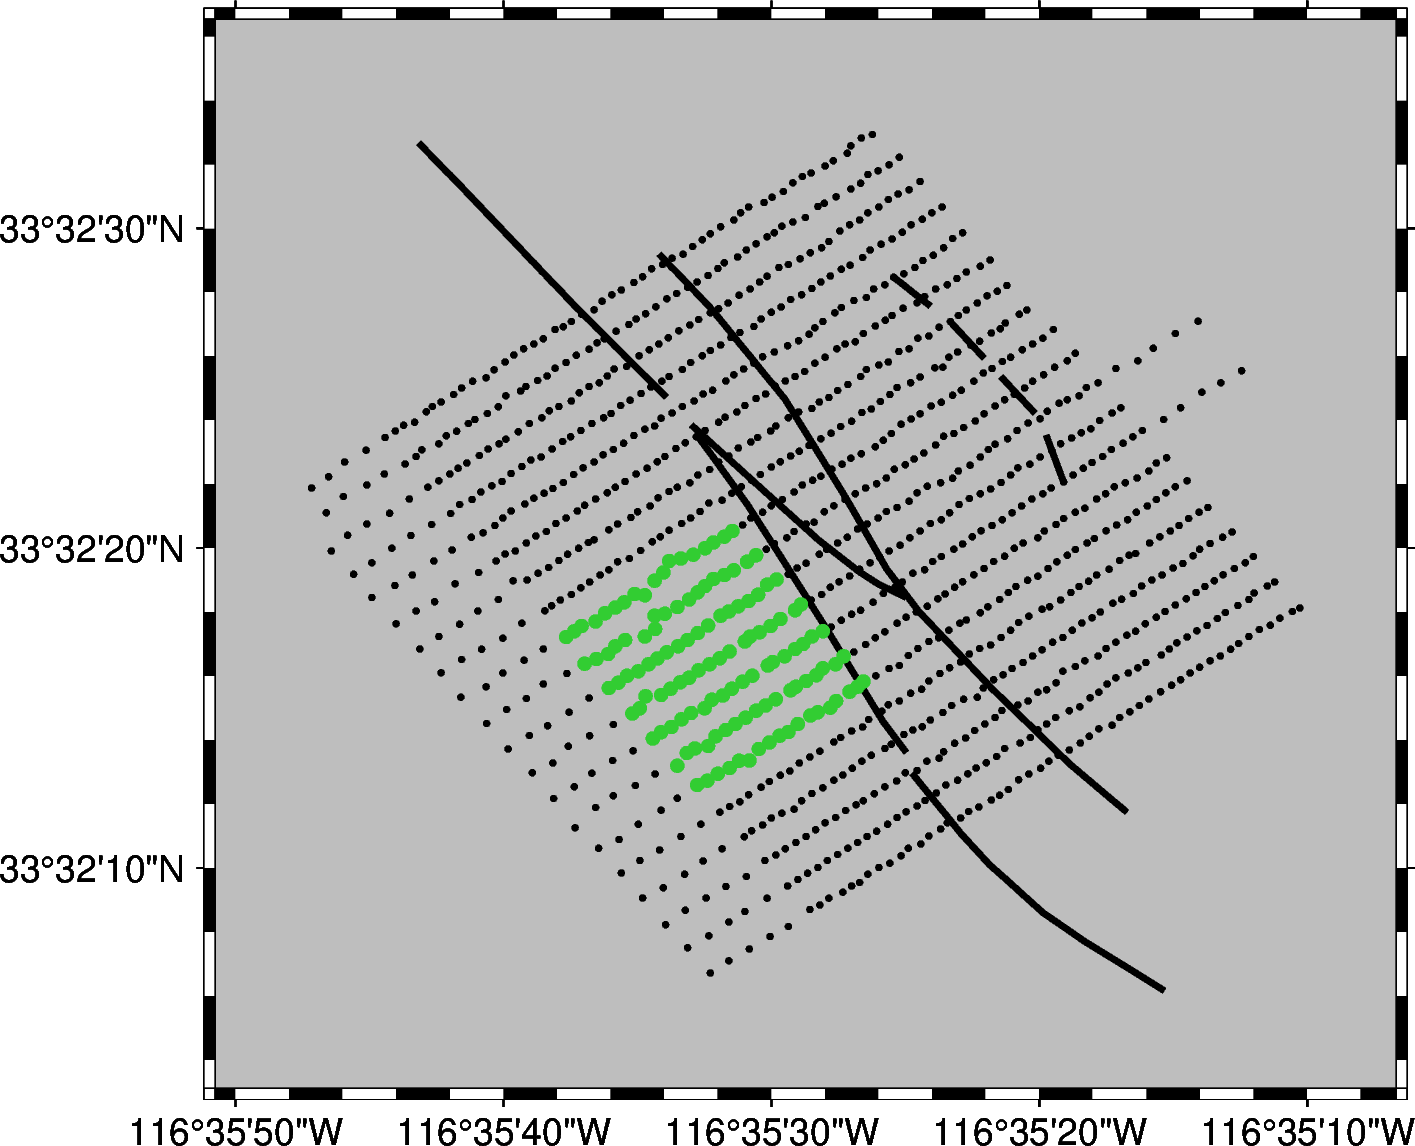

In [228]:
key_subwork = '1--19-09--0.03'
key_target = '19-09'
# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.12',fill='limegreen')
#fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.15',fill = 'yellow')
#fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.12',pen='2p,blue')
#fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'thresh_partition_'+key_target+'.eps')

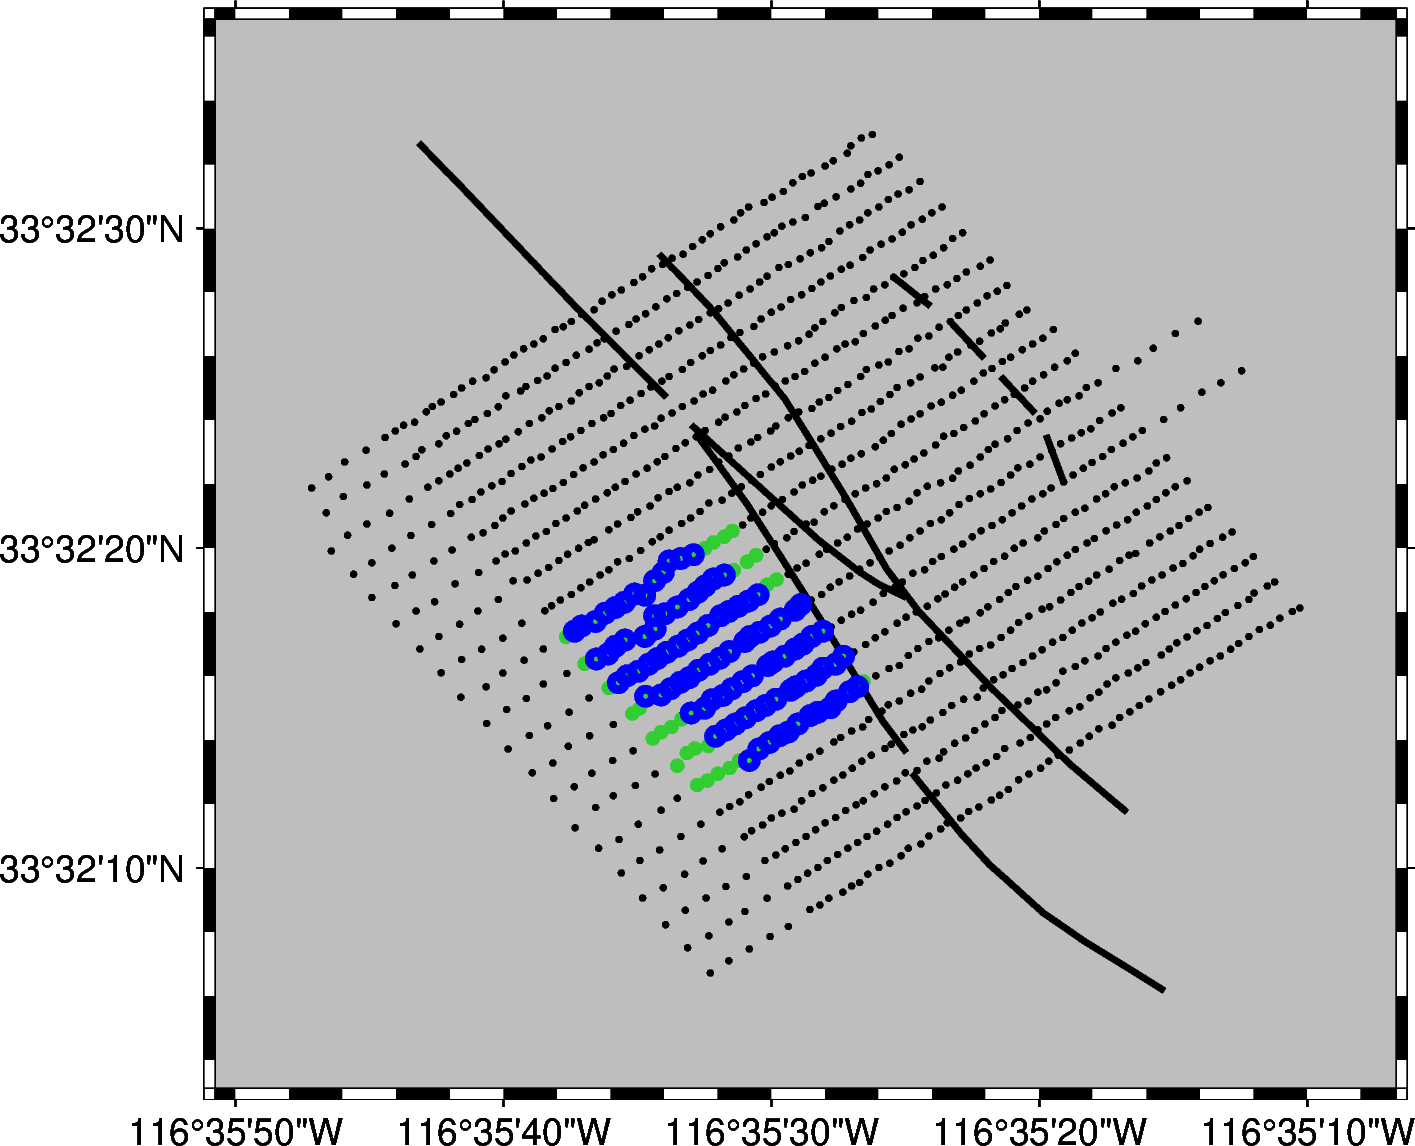

In [229]:
key_subwork = '1--19-09--0.03'
key_target = '19-09'
# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.12',fill='limegreen')
#fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.15',fill = 'yellow')
fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.12',pen='2p,blue')
#fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'thresh_partition_'+key_subwork+'.eps')

set()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


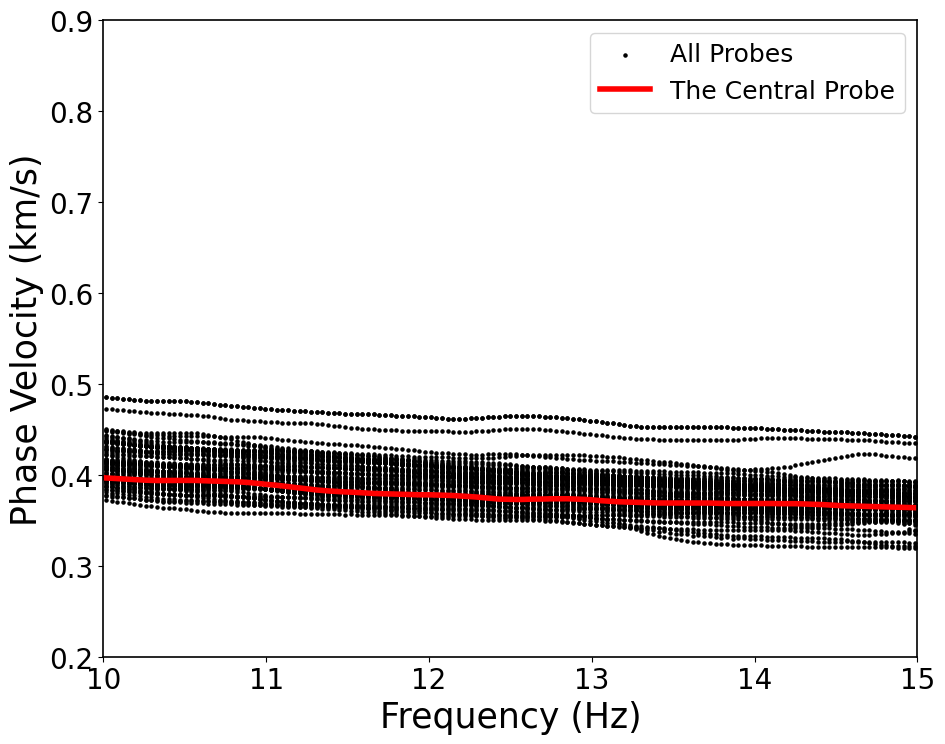

In [230]:
flag_err = 0.04
f_sample,c_pick,c_pick_ref,probe_pass = extract_err(key_target,flag_err)
inter = 1
fig = plt.figure(figsize=(10,8))
plt.style.use('tomo_paper.mplstyle')
ax = fig.add_subplot(111)
for probe in probes_this:
    if probes_this.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.',label='All Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.')
ax.plot(f_sample,c_pick_ref,'r',lw=4,label='The Central Probe')
probe_pass = list(probe_pass)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.set_xlim(10,15)
ax.set_ylim(0.2,0.9)
ax.legend()
plt.tight_layout()
fig.savefig(dir_image+'thresh_disps_'+key_target+'.eps')

set()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


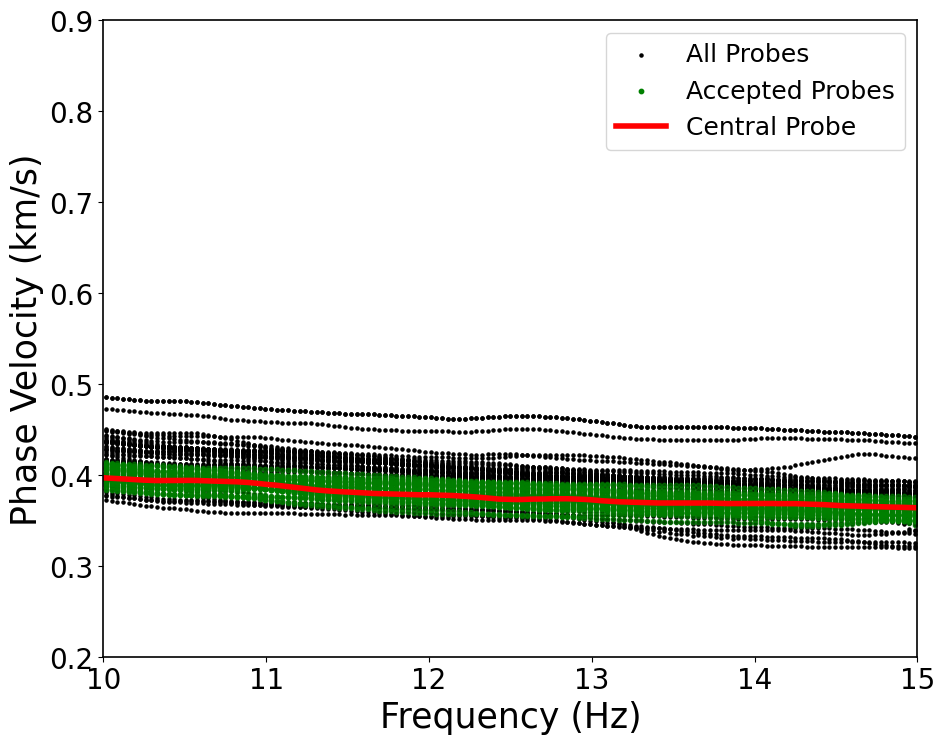

In [231]:
flag_err = 0.04
f_sample,c_pick,c_pick_ref,probe_pass = extract_err(key_target,flag_err)
inter = 1
fig = plt.figure(figsize=(10,8))
plt.style.use('tomo_paper.mplstyle')
ax = fig.add_subplot(111)
for probe in probes_this:
    if probes_this.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.',label='All Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.')
probe_pass = list(probe_pass)
for probe in probe_pass:
    if probe_pass.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',label='Accepted Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',alpha=0.6)
ax.plot(f_sample,c_pick_ref,'r',lw=4,label='Central Probe')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.set_xlim(10,15)
ax.set_ylim(0.2,0.9)
ax.legend()
plt.tight_layout()
fig.savefig(dir_image+'thresh_disps_'+key_subwork+'.eps')

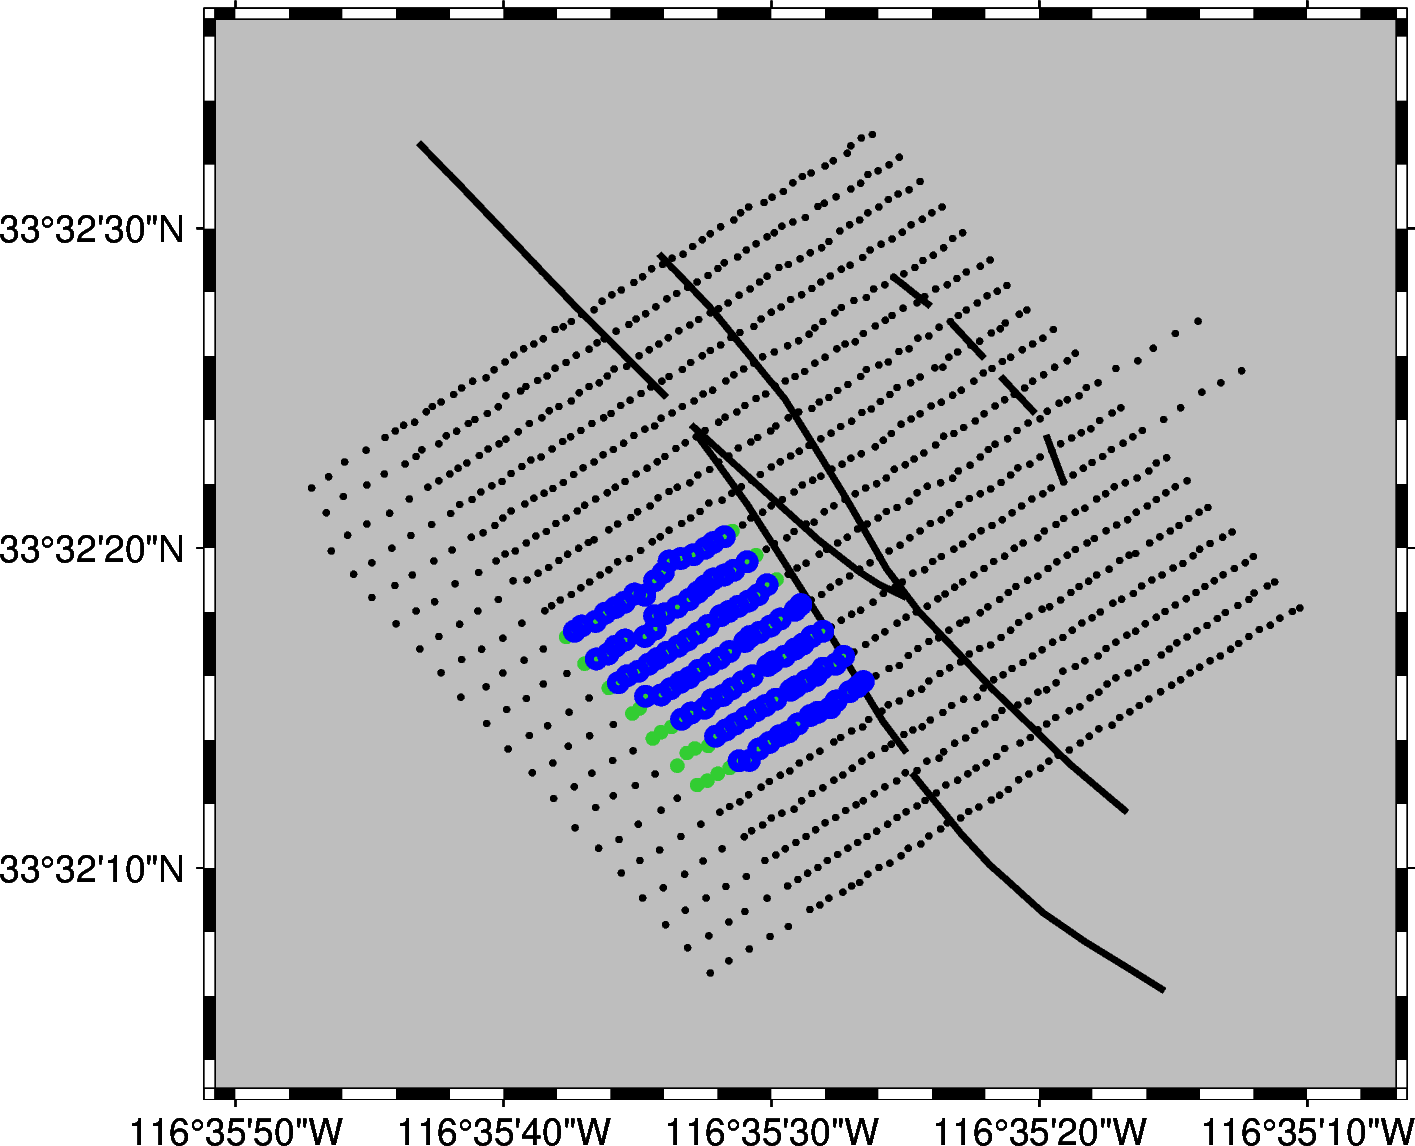

In [232]:
key_subwork = '1--19-09--0.05'
key_target = '19-09'
# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.12',fill='limegreen')
#fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.15',fill = 'yellow')
fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.12',pen='2p,blue')
#fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'thresh_partition_'+key_subwork+'.eps')

set()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


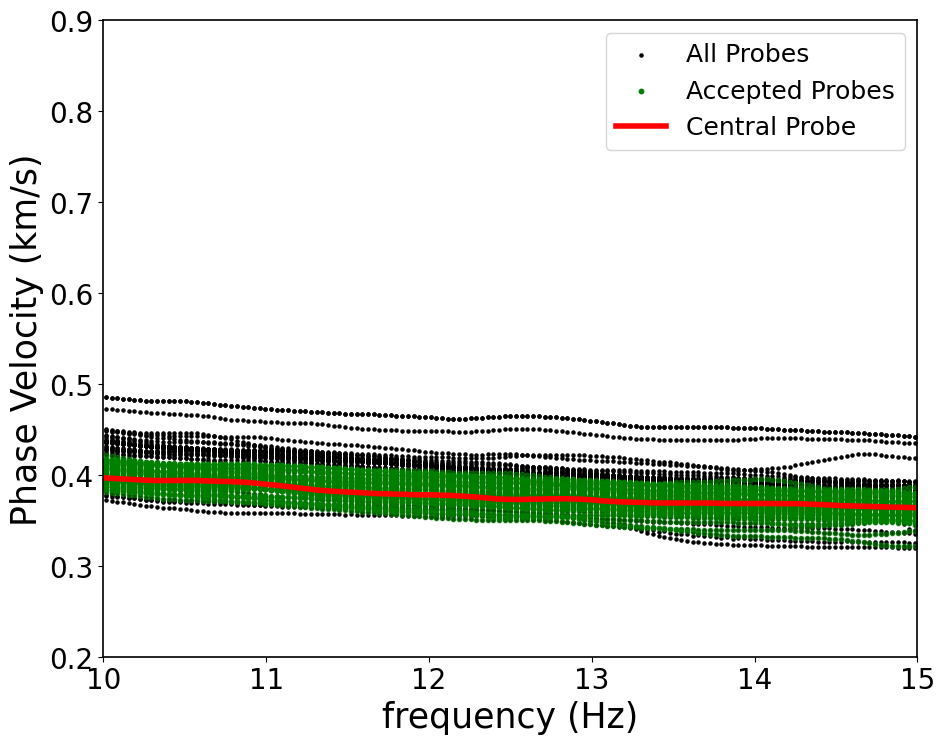

In [233]:
flag_err = 0.055
f_sample,c_pick,c_pick_ref,probe_pass = extract_err(key_target,flag_err)
inter = 1
fig = plt.figure(figsize=(10,8))
plt.style.use('tomo_paper.mplstyle')
ax = fig.add_subplot(111)
for probe in probes_this:
    if probes_this.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.',label='All Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.')
probe_pass = list(probe_pass)
for probe in probe_pass:
    if probe_pass.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',label='Accepted Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',alpha=0.6)
ax.plot(f_sample,c_pick_ref,'r',lw=4,label='Central Probe')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.set_xlim(10,15)
ax.set_ylim(0.2,0.9)
ax.legend()
plt.tight_layout()
fig.savefig(dir_image+'thresh_disps_'+key_subwork+'.eps')

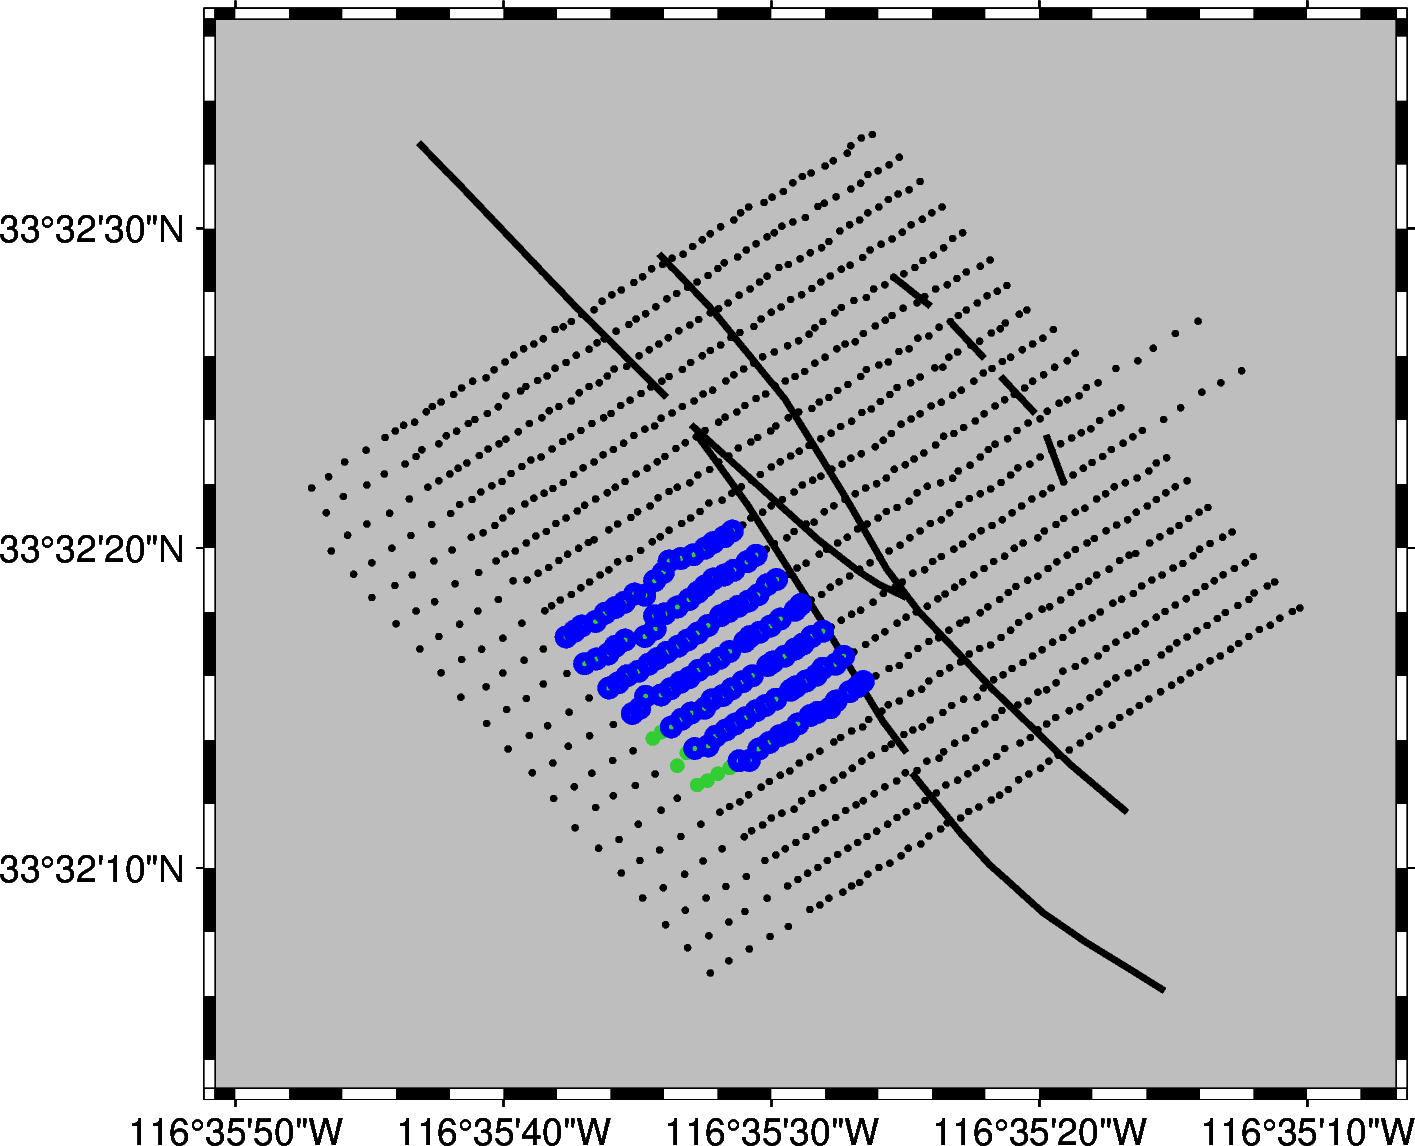

In [234]:
key_subwork = '1--19-09--0.08'
key_target = '19-09'
# 读取全部autopick dispersion curves
probes_this = extract_probes(key_target)
# find central probe and cluster based on it
index = find_nearest(lon_centroid_targets[targets.index(key_target)],lat_centroid_targets[targets.index(key_target)],lon_centroid_probes,lat_centroid_probes)
probe_ref = probes[index]
# original partition
sta_original = set()
for probe in probes_this:
    sta_original = sta_original.union(stations_probes[probe])
sta_original = list(sta_original)
lon_stations_original = []
lat_stations_original = []
for sta in sta_original:
    index = stalist_all.index(sta)
    lon_stations_original.append(lon_stations_all[index])
    lat_stations_original.append(lat_stations_all[index])

fig = pygmt.Figure()
fig.basemap(
    region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],
    projection=flag_proj, 
    frame=True,
)
# stations and faults
fig.coast(region=[np.min(lon_stations_all)-flag_red, np.max(lon_stations_all)+flag_red, np.min(lat_stations_all)-flag_red, np.max(lat_stations_all)+flag_red],projection=flag_proj, frame=True, land="gray")
fig.plot(x=lon_stations_all, y=lat_stations_all, fill='black', style='c0.06')
for j in range(len(faults)):
    if j == 0:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'], pen = "1.5p,black")
    else:
        fig.plot(x=faults['clark'+str(j+1)]['lon'], y=faults['clark'+str(j+1)]['lat'],pen = "1.5p,black")
fig.plot(x=lon_fault_infer, y=lat_fault_infer, pen = "1.5p,black,-")
# original partition
fig.plot(x=lon_stations_original, y=lat_stations_original, style='c0.12',fill='limegreen')
#fig.plot(x=lon_targets[key_target], y=lat_targets[key_target], style='c0.15',fill = 'yellow')
fig.plot(x=lon_stations_partition[key_subwork], y=lat_stations_partition[key_subwork],style='c0.12',pen='2p,blue')
#fig.plot(x=lon_centroid_targets[targets.index(key_target)], y=lat_centroid_targets[targets.index(key_target)], style='t0.2',fill = 'red')
#fig.plot(x=np.mean(lon_stations_partition[key_subwork]),y = np.mean(lat_stations_partition[key_subwork]), style='a0.2',fill = 'red')
fig.show()
fig.savefig(dir_image+'thresh_partition_'+key_subwork+'.eps')

set()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


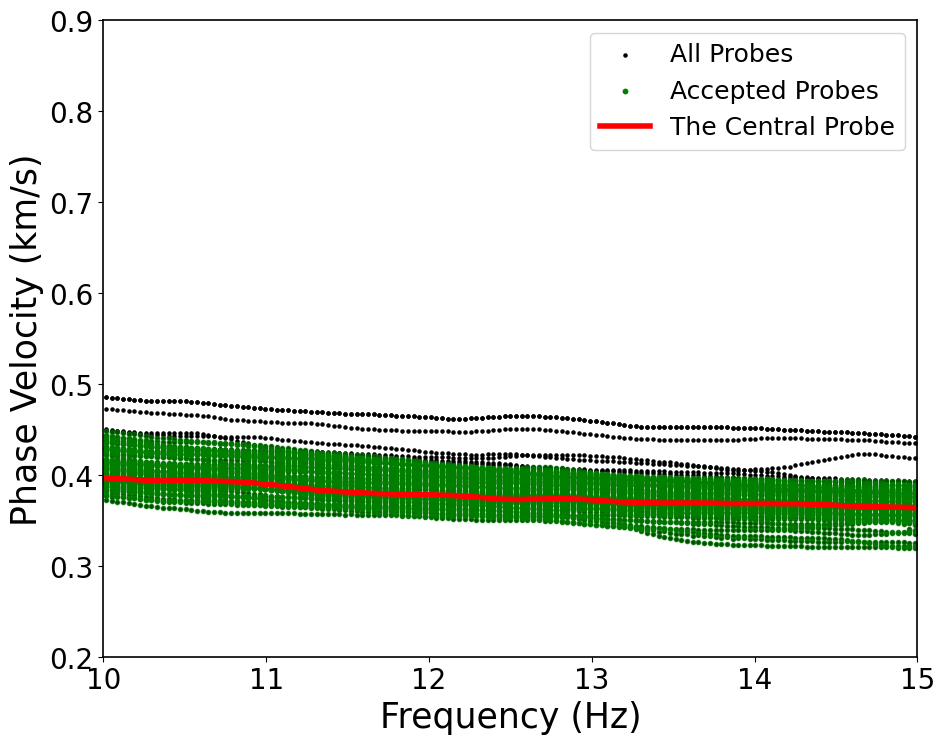

In [235]:
flag_err = 0.08
f_sample,c_pick,c_pick_ref,probe_pass = extract_err(key_target,flag_err)
inter = 1
fig = plt.figure(figsize=(10,8))
plt.style.use('tomo_paper.mplstyle')
ax = fig.add_subplot(111)
for probe in probes_this:
    if probes_this.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.',label='All Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='k',s=20,marker='.')
probe_pass = list(probe_pass)
for probe in probe_pass:
    if probe_pass.index(probe) == 0:
        ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',label='Accepted Probes')
    ax.scatter(f_sample[::inter],c_pick[probe][::inter],c='g',s=40,marker='.',alpha=0.6)
ax.plot(f_sample,c_pick_ref,'r',lw=4,label='The Central Probe')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (km/s)')
ax.set_xlim(10,15)
ax.set_ylim(0.2,0.9)
ax.legend()
plt.tight_layout()
fig.savefig(dir_image+'thresh_disps_'+key_subwork+'.eps')